# Abstract

 Word2Vec을 활용하여 연도별로 GNI 코퍼스 내의 keywords들을 Clusturing한다.

# 1. 라이브러리 import
 Word clustering과 Visualization에 필요한 라이브러리를 import한다. G&I 코퍼스의 Word Embedding을 위해서 Word2Vec를, Word clustering을 위해서 KMeans를 추가한다. 전처리에 사용되는 모듈은 re와 nltk.corpus 내의 stopwords와 nltk.WordNetLemmatizer이며, 클러스터링 한 결과를 시각화 하기 위해서 matplotlib.pyplot, sklearn 패키지의 MDS, cosine_similarity를 추가한다.

In [1]:
# import nltk
import nltk
from nltk.corpus import *
from nltk import *

# libraries for word clustering
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import joblib

# import libraries for preprocessing
import re

# libraries for visualization
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

import time

# 2. G&I corpus reader
Nltk.corpus.PlaintextCorpusReader를 이용하여 sentence_tokenized 폴더 내의 모든 G&I코퍼스들을 읽는다.

In [2]:
# using sentence tokenized gni corpus.
corpus_root = 'C:/Users/Maeg/nltk_data/Genomics-Informatics-Corpus-master/Genomics-Informatics-Corpus-master/GNI Corpus 1.0/sentence_tokenized'
GNIcorpus = PlaintextCorpusReader(corpus_root,'.*\.txt',encoding='utf-8')


# 3. Preprocessing
G&I코퍼스를 전처리한다. Sentence_tokenized폴더 내의 G&I코퍼스는 문장 분할이 된 상태이다. 따라서  GNIcorpus.sents()를 이용하여 문장과 각 단어를 분할한다. Word Clustering은 G&I 논문의 키워드 중심으로 클러스터링이 되므로, 코퍼스 문장 내에서 stop word, non-letter들을 제거한다. 또한 복수표현, 시제표현을 WordNetLemmatizer()로 원형으로 전환해 입력한다.
 전처리한 문장 리스트는 Word2Vec의 input의 shape와 통일 시켜, 단어로 토큰화 된 문장의 리스트로 리턴한다.

In [3]:
# preprocessing each sentence
def gni_preprocessed_sents(gni_sents):
    
    # load stopwords and initialize preprocessed sentences list
    stops = set(stopwords.words("english"))
    wnl = nltk.WordNetLemmatizer()
    gni_pre_sents = []
    
    # remove non-letter words and stop words in each sentence
    for s in gni_sents :
        sent = []
        for w in s :
            if (re.match(r'[a-zA-Z0-9]+',w) !=  None) & (not w in stops) :
                sent.append(wnl.lemmatize(w.lower()))
        gni_pre_sents.append(sent)
    
    # return preprocessed sentences list
    return gni_pre_sents

In [4]:
# preprocessing GNI corpus
print("Start preprocessing... : G&I sentences")
gni_sents = gni_preprocessed_sents(GNIcorpus.sents())
print("End preprocessing: G&I sentences")

Start preprocessing... : G&I sentences
End preprocessing: G&I sentences


# 4. Word2Vec Modeling and Training
 Word2Vec 모델을 구축하고 학습시킨다. 모델의 파라미터는 다음과 같다. (workers) 모델 학습 시 병렬 학습을 위한 모듈 수는 4로 하였다. (size) 모델의 특징 개수은 300으로 설정하였다. (min_count) 최소한 40번 이상의 빈도수를 가진 단어들만 모델에 입력된다. (window) 문장 내에서 단어의 전후 10단어의 단어를 고려하여 문맥을 파악한다. (sample) 너무 자주 등장하는 단어에 의해서 편향된 결과가 나타나는 것을 방지하기 위해 다운 샘플링 값을 0.001로 설정한다.<br><br>
  학습 후에는 효율적인 메모리 관리를 위해 model.init_sims()로 불필요한 메모리를 정리한다.<br><br>
  학습된 모델을 특징개수, 최소 빈도수, window개수 정보를 이름에 포함하여 저장한다.

In [15]:
n_features = 300       # the number of Word2Vector Dimension
min_wordcount = 40     # Words which counts at least 20 times are available
n_workers = 4          # the number of parallel work
size_boundary = 6      # contextual window size
downsampling = 1e-3    # down sampling with frequent words

# Initialize and train Word2Vec model
print("Start Training ...")
model = Word2Vec(gni_sents,
                 workers = n_workers,
                 size = n_features,
                 min_count = min_wordcount,
                 window = size_boundary,
                 sample = downsampling)
print("End Training ")

# manage memory
model.init_sims(replace=True)

# save trained model
model.save("GNI_"+str(n_features)+"features_"+str(min_wordcount)+"minwords_"+str(size_boundary)+"window")

Start Training ...
End Training 


# 5. Word Clustering

Word2Vec 모델에서 wv(Word vector) attribute를 참조할 수 있다. wv는 해당 모델에 입력된 단어(vocab)와 해당 단어들의 벡터값(vectors)를 포함하여 클러스터링에 필요한 벡터값을 얻을 수 있다. 클러스터의 개수는 모델의 단어 개수의 5분의 1로 설정하였다. <br><br>
 KMeans 객체에 클러스터의 개수(n_clusters)를 설정하고, fit_predict() 메소드에 인자를 단어의 벡터값gniwv.vectors)을 입력하여 클러스터링을 진행한다. 클러스터링 후 클러스터링에 소요된 시간, 벡터의 개수, 클러스터의 개수와 같은 클러스터링 결과를 요약하여 출력한다.

In [16]:
# clustering start time
start = time.time()
print("Start: Clustering")

# word vector of word2Vec model
gniwv = model.wv

# set the number of cluster
num_clusters = (int)(len(gniwv.vocab) / 5)

# Initialize a k-means object and use it to extract centroids(cluster)
kmeans_clustering = KMeans( n_clusters = num_clusters)
index = kmeans_clustering.fit_predict(gniwv.vectors)

end = time.time()
clustering_time = end - start
print("End  : Clustering")

# print Clustering information
print("\n============== Clustering Information ==============")
print("Clustering time:", clustering_time)
print("# of Word vectors:", len(gniwv.vocab))
print("# of Clusters:", num_clusters)

Start: Clustering
End  : Clustering

============== Clustering Information ==============
Clustering time: 58.272836685180664
# of Word vectors: 2191
# of Clusters: 438


 클러스터링한 결과를 .pkl 파일로 저장한다.

In [17]:
# save the cluster models
joblib.dump(kmeans_clustering, 'GNI_words_cluster_window'+str(size_boundary)+'.pkl')

['GNI_words_cluster_window6.pkl']

 Word_centroid_map에 모델의 각 단어와 해당 단어가 포함된 클러스터 넘버를 딕셔너리 형태로 저장한다. 클러스터링 결과를 클러스터 별로 출력한다.

In [18]:
# word - cluster number matching
word_centroid_map = dict(zip(gniwv.index2word, index))

# Print whole clutering results
for cluster in range(num_clusters) :
    print('\nCluster',cluster)
    words = []
    for k, c in word_centroid_map.items():
        if c == cluster :
            words.append(k)
    print(words)


Cluster 0
['mir', '21', '3p']

Cluster 1
['commonly', 'detecting', 'biomarker', 'validate', 'successfully', 'confirm', 'compositional', 'deps', 'ethnicity', 'tried', 'examine', 'meaningful']

Cluster 2
['maf', 'yorkshire', 'oh', 'landrace']

Cluster 3
['collection', 'hybridization', '2000', 'parallel', 'clone', 'mgiseq', 'quantity']

Cluster 4
['altered', 'closely', 'ro', 'neuronal']

Cluster 5
['red', 'blue', 'green', 'box']

Cluster 6
['putative', 'downstream', 'localization', 'encoding', 'transfer', 'hp1', 'folding', 'acinetobactin']

Cluster 7
['each', 'third', 'instead', 'representing', 'clustered', 'displayed', 'separate', 'character', 'assessed']

Cluster 8
['hypertension', 'hearing', 'poor', 'cardiovascular', 'symptom', 'coronary']

Cluster 9
['measure', 'combination', 'evaluated', 'calculation', 'predictor', 'multivariate']

Cluster 10
['requires', 'extraction', 'created', 'taxonomic', 'storage', 'object', 'image', 'store', 'create']

Cluster 11
['new', 'application', 'knowle

['proportion', 'substitution']

Cluster 113
['term', 'go', 'enrichment']

Cluster 114
['resulting', 'occurs', 'island']

Cluster 115
['another', 'design', 'future', 'needed', 'become', 'focus', 'develop']

Cluster 116
['testing', 'our', 'would', 'better', 'determine', 'improve', 'difficult', 'investigate', 'dtc', 'interpretation', 'evaluate', 'consumer', 'aimed']

Cluster 117
['thousand', 'hundred', 'ten']

Cluster 118
['main', 'good', 'basis', 'consider', 'rule', 'screen', 'building', 'tensor', 'artificial', 'reliability', 'decision']

Cluster 119
['an', 'while', 'evaluation', 'take', 'proper', 'theory', 'apply', 'adopted', 'vocabulary', 'combine', 'enable', 'avoid', 'inference']

Cluster 120
['number', 'small', 'copy', 'across']

Cluster 121
['often', 'relation', 'signature', 'distinct', 'majority', 'exist', 'functionally', 'spatial', 'occurring']

Cluster 122
['project', 'international', 'consortium', 'tcga', '1000']

Cluster 123
['response', 'cycle', 'induced', 'apoptosis', 'prolif

['element', 'alu', 'deletion', 'insertion']

Cluster 238
['95', '60', 'min', 'mm', '70', 'mg', 'day', '72', '120', 'temperature', 'dl']

Cluster 239
['1', '2', '3', '4']

Cluster 240
['change']

Cluster 241
['dna']

Cluster 242
['specific']

Cluster 243
['association', 'effect', 'locus', 'bmd']

Cluster 244
['show']

Cluster 245
['we']

Cluster 246
['90', 'interval', '99', '69', '04', 'ranging', '98', 'gc', 'sd', '71', 'upper', '91', '93', 'ranged']

Cluster 247
['conducted', 'article', 'published']

Cluster 248
['with', 'wes', 'deep', 'rapidly', 'metagenome', 'massive', 'availability', 'hybrid', 'enabled']

Cluster 249
['mutant', 'wild']

Cluster 250
['cluster', 'represented', 'assigned', 'symbol']

Cluster 251
['generally', 'usually', 'efficiency', 'correct', 'adaptation']

Cluster 252
['chromatin', 'modification', 'histone', 'mark']

Cluster 253
['rt', 'volume', 'gel', 'separated', 'mixture', 'buffer', 'extension', 'plate', 'electrophoresis', 'mix', 'oligonucleotides', 'tank']

Clus

['sequence']

Cluster 399
['tool', 'system', 'text', 'bioinformatics', 'public', 'source', 'currently']

Cluster 400
['therefore', 'understanding', 'help', 'understand', 'insight', 'relevant', 'yet', 'importance', 'underlying']

Cluster 401
['time']

Cluster 402
['of', 'mtdna', 'autosomal', 'platelet', 'heterozygosity', 'heterozygous']

Cluster 403
['involved', 'activation', 'regulate', 'abnormal', 'regulator', 'oncogene', 'regulating']

Cluster 404
['pc', 'flow', 'western']

Cluster 405
['set']

Cluster 406
['infection', 'immune', 'pathogenesis', 'pathogen', 'uterine']

Cluster 407
['tree', 'us', 'suffix']

Cluster 408
['enriched', 'overlapped']

Cluster 409
['database']

Cluster 410
['discovery', 'screening']

Cluster 411
['signaling', 'production', 'involvement', 'emt', 'tm4sf5', 'oncogenic', 'rage', 'secretion', 'stress', 'biosynthesis', 'tmprss4', 'enhanced', 'inflammation', 'induction', 'cytokine', 'transduction', 'induces', 'senescence']

Cluster 412
['polymorphism', 'akt2', 'ak

# 6. Multidimensional Scaling
 결과를 시각화 하기 위해서 단어 벡터들을 2차원의 형태로 변환시킨다. 우선 각 단어 벡터들 간의 코사인 유사도(cosine_similarity())를 구한 후, 1-코사인유사도로 분포 값을 정의한다. Dist는 각 벡터간의 거리를 의미하며 (단어의 개수)*(단어의 개수) 크기의 배열이다.<br><br>
MDS을 활용하여 차원을 압축한다. (n_components) 결과로 나오는 차원의 개수는 2차원이므로 2로 설정하였다. (dissimilarity) 차원 압축시에는 거리 매트릭스(distance matrix)가 필요한데, dist를 통해 단어간 거리값을 입력해주므로 dissimilarity 옵션을 precomputed로 설정한다.<br><br>
 Pos에 2차원으로 변환된 각 단어들의 위치가 저장된다. 각 단어의 X좌표를 xs에, Y좌표를 ys에 저장한다.


In [9]:
# calculate distribution
dist = 1-cosine_similarity(gniwv.vectors)

# initialize MDS
MDS()

# scaling multidimensions
mds = MDS(n_components=2, dissimilarity = "precomputed", random_state=1)
pos = mds.fit_transform(dist)

xs, ys = pos[:,0], pos[:,1]

# 7. Visualization of Word vectors
모든 클러스터의 개수는 465개로 한 번에 표시하기에 너무 큰 개수였다. 따라서 대표로 35부터 39까지 5개의 클러스터만 골라 출력하기로 한다. 시각화될 5개의 클러스터들의 이름과 표시 색을 지정한다.<br><br>
2차원으로 변환된 x좌표(x=xs)와 y좌표(y=ys), 단어(word=gniwv.index2word), 클러스터 번호(label=index) 4가지 열로 구성된 데이터 프레임 df_all을 구축한다. Label 열의 값을 35이상 40미만으로 필터링하여 cluster35~39 데이터만 df에 저장한다. 클러스터(label)별로 시각화해야 하기위해  df.groupby(‘label’)로 그룹화한다.

In [10]:
# set colors and names of clusters
cluster_colors = {35: '#1b9e77', 36: '#d95f02', 37: '#7570b3', 38: '#e7298a', 39: '#66a61e'}
cluster_names = {35: 'Cluster35', 
                 36: 'Cluster36', 
                 37: 'Cluster37', 
                 38: 'Cluster38', 
                 39: 'Cluster39'
                }

In [11]:
%matplotlib inline

# Create (x-position(2D), y-position(2D), word, cluster number) table
df_all = pd.DataFrame(dict(x=xs, y=ys,word=gniwv.index2word, label=index))

# Show only five Clusters, 35, 36, 37, 38, 39
condition = ( df_all['label'] >= 35 ) & ( df_all['label'] < 40 )
df = df_all[condition]

# grouping with cluster number
groups = df.groupby('label')
df

,x,y,word,label
2,0.150190,-0.712403,1,39
6,0.241276,-0.705372,2,39
15,0.274979,-0.696644,3,39
35,0.177134,-0.709551,4,39
437,-0.553203,0.005086,validation,35
663,-0.301840,-0.077384,finally,35
771,-0.384693,-0.133715,then,35
798,-0.471210,-0.151577,cross,35
890,-0.154344,-0.467135,yeast,36
1032,0.408951,-0.106546,mitochondrial,38


 df를 시각화 한다. ax는 시각화 될 내용을 정한다. 여백은 0.05로 설정하였다. 클러스터별(name)로 x좌표(group.x), y좌표(group.y)를 원모양(‘o’)으로 사전의 설정한 색과 이름을 부여한다. Df를 다시 참조하여 각 좌표에 단어(df.iloc[i][‘word’])를 크기 12로 표시한다.

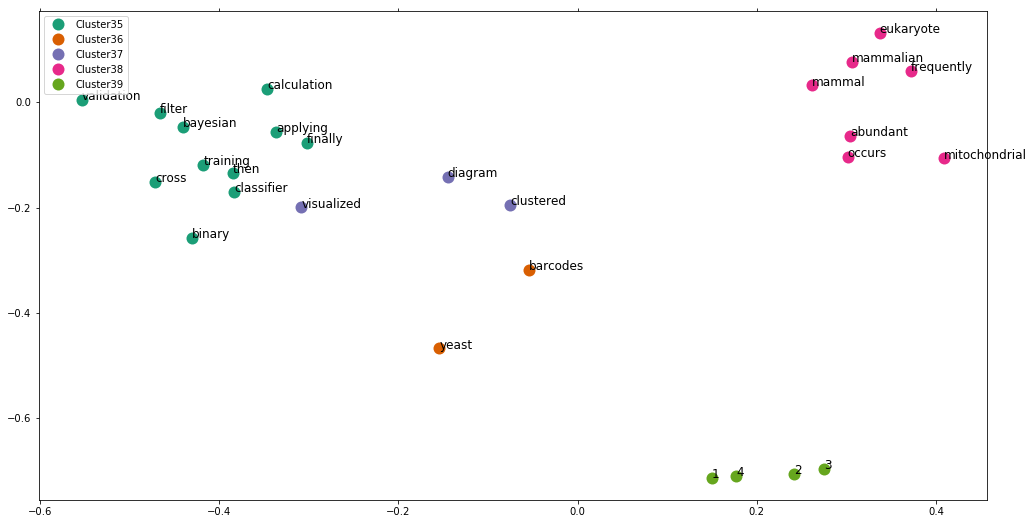

In [12]:
fig, ax = plt.subplots(figsize=(17, 9)) # set size

ax.margins(0.05)

for cluseter_n, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=cluster_names[cluseter_n],
            color=cluster_colors[cluseter_n], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)

for i in range(len(df)):
    ax.text(df.iloc[i]['x'],
            df.iloc[i]['y'],
            df.iloc[i]['word'], size=12)  
plt.show()

# 8. Searching the Cluster with a words
 주어진 키워드가 포함된 클러스터를 출력하는 함수 find_cluster_with_key()를 정의하였다. 해당 함수는 키워드(key)를 인자로 받는다. 주어진 키워드가 어떤 클러스터에도 존재하지 않을 경우, 오류 메세지를 출력한다. 반대의 경우, 해당 키워드가 포함된 클러스터의 번호와 같은 클러스터에 포함된 키워드들을 모두 출력한다.

In [13]:
# find cluster result with specipic keyword
def find_cluster_with_key(key):
    # if there is not key in vocab, do nothing
    if not key in word_centroid_map.keys() :
        print("That word is not in keys")
    # if there is key in vocab, print cluster result
    else :  
        cluster = word_centroid_map[key]
        print('\nCluster',cluster)
        words = []
        for k, c in word_centroid_map.items():
            if c == cluster :
                words.append(k)
        print(words)

In [14]:
key = input("============= Find Clustering ==============\nEnter a keyword: ")
find_cluster_with_key(key)


============= Find Clustering ==============
Enter a keyword: 1

Cluster 39
['1', '2', '3', '4']
